In [1]:
import random
import math
import re
import numpy as np
import matplotlib.pyplot as plt

取鸾尾花数据的两个特征维度展示

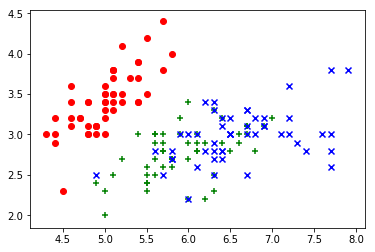

In [2]:
with open('iris.txt','r') as f:
    trainset = []
    for train_line in f:
      train_line = train_line.strip()
      train_L = re.split(',|;|\t| ',train_line)
      trainset.append([float(x) for x in train_L[:-1]])
    # print (trainset[:50])
x0 = np.array(trainset[:50])
x1 = np.array(trainset[50:100])
x2 = np.array(trainset[100:150])
# print(x0[:,0])
plt.scatter(x0[:,0],x0[:,1],c='r',marker='o',label='setosa(山鸢尾)')
plt.scatter(x1[:,0],x1[:,1],c='g',marker='+',label='virgincia(维吉尼亚鸢尾)')
plt.scatter(x2[:,0],x2[:,1],c='blue',marker='x',label='versicolor(变色鸢尾)')

In [3]:
#SVM_parameter用于存储SVM需要用到的参数
class SVM_parameter():
  def __init__(self,trainset,trainlabel,C,toler,kernel_type,sigma):
    self.trainset = trainset
    self.trainlabel = trainlabel
    self.N = len(trainset)#样本个数
    self.d = len(trainset[0])#特征个数
    self.C = C
    self.alph = [0.]*self.N#
    self.b = 0.
    self.error_cache = [0.]*self.N#N维的list存储deltaE
    self.toler =toler
    self.two_sigma_squared= 2*sigma**2
    self.kernel = kernel_type


多分类代码的思路是先完成第一个类和其余类的二分类问题，再完成第二个类和其余类的二分类问题
依次进行，这样就可以完成所有类的分类问题了。
训练SVM，要求：输入训练集数据，以及C（惩罚参数，默认为1），toler精确度（默认为1），kernel_type（核函数，可以选择高斯核:"rbf"与线性核:"linear"），sigma(kernel_type 为高斯核)


In [4]:
def train_SVM(train_file_name,C=1.0,toler=0.001,kernel_type="linear",sigma=0.5):
  with open(train_file_name,'r') as f:
    trainset = []
    raw_train_labels_L1 = []#所有样本原始训练标签，用于计数
    raw_train_labels_L2 = []#原始训练标签种类（即几分类），用于循环
    for train_line in f:
      train_line = train_line.strip()
      train_L = re.split(',|;|\t| ',train_line)
      trainset.append([float(x) for x in train_L[:-1]])
      if train_L[-1] not in raw_train_labels_L2:#获取标签种类，以及对应标签的数目
        raw_train_labels_L1.append(train_L[-1])
        raw_train_labels_L2.append(train_L[-1]) 
      else:
        raw_train_labels_L1.append(train_L[-1])
    print (raw_train_labels_L1,raw_train_labels_L2)
  #循环分类的次数为标签种类数
  if len(raw_train_labels_L2) == 2:#如果分类标签个数是二，直接二分类就行
    trainlabel = []
    for i in raw_train_labels_L1:#输入标签
      if i == raw_train_labels_L1[0]:
        trainlabel.append(1)
      else:
        trainlabel.append(-1)
        
    svm = SVM_parameter(trainset,trainlabel,C,toler,kernel_type,sigma)#获取参数
    MainRoutine(svm)#调用SMO算法主函数
    classifier = svm#二分类分类器直接为SVM类  
  else:#多分类
    classifier = []
    for sample1 in raw_train_labels_L2:#循环，每个类别单独拿出来和其余类别进行二分类
      trainlabel = []    
      for element in raw_train_labels_L1:#第一个分类的标签设为1，其余类别的标签设为-1，以此类推
          if element == sample1:
            trainlabel.append(1)
          else:
            trainlabel.append(-1)
      #多分类下进行二分类
      svm = SVM_parameter(trainset,trainlabel,C,toler,kernel_type,sigma)  
      MainRoutine(svm)
      classifier.append(svm)#多分类分类器存储在列表中
  return classifier#训练集返回训练的分类器


In [5]:
def test_SVM(test_file_name,classifier):
  with open(test_file_name,'r') as f:
    global testset
    testset = []
    raw_test_labels_L1 = []#原始测试标签
    raw_test_labels_L2 = []#
    for test_line in f:
      test_line = test_line.strip()
      test_L = re.split(',|;|\t| ',test_line)
      testset.append([float(x) for x in test_L[:-1]])
      if test_L[-1] not in raw_test_labels_L2:#获取标签种类，以及对应标签的数目
        raw_test_labels_L1.append(test_L[-1])
        raw_test_labels_L2.append(test_L[-1])
      else:
        raw_test_labels_L1.append(test_L[-1])

  if len(raw_test_labels_L2) == 2:#如果分类标签个数是二，直接可以使用测试数据
    testlabel = []
    for i in raw_test_labels_L1:#输入标签
      if i == raw_test_labels_L1[0]:
        testlabel.append(1)
      else:
        testlabel.append(-1)
    rate = accuracy(classifier,testset,testlabel)
    
  else:#多分类测试
    #循环，每个输入样本用训练好的所有分类器去分类，得分最高（即分类效果最好）的为相应的分类结果
    right_count = 0
    for sample in testset:
      sample_label = 1
      #对于每一类样本来说，都有其对应的召回率和精确率。
      #多个训练器获取最优的训练器和正确率      
      max_output = 0 #获取得分最高的分数
      for i in range(len(classifier)):
        output = learned_func(classifier[i],testset.index(sample),is_test=1)
        if output > max_output:
          max_output = output
        else:
          continue
      if max_output*sample_label >= 0.0:#如果得分最高的分数大于0，则认为分类正确
        right_count += 1
    rate = 100.0*right_count/len(raw_test_labels_L1)
  return rate
 

In [6]:
def learned_func(svm,k,is_test = 0):
  w_x = 0.
  for i in range(svm.N):
    if svm.alph[i] > 0:
      ################################################################################
      # TODO:             写出 w*x                                                    #
      ################################################################################
      # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

      w_x+=svm.alph[i]*svm.trainlabel[i]*kernel_func(svm,i,k,is_test)


      # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  v = w_x - svm.b   ###目标函数：wx-b
  return v

In [7]:
def dot_product_func(svm,i1,i2,is_test = 0):#计算两个样本的点积
    dot = 0.
    if is_test == 0:    #训练
        for i in range(svm.d):
            dot += svm.trainset[i1][i]*svm.trainset[i2][i]
    ################################################################################
    # TODO:            一共有三种情况，写出剩下两种if                                   #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    elif is_test !=0 and i1!= i2: ##考虑 testset[i2]
        for i in range(svm.d):
            #pass
            dot+=svm.trainset[i1][i]*testset[i2][i]
    else:
        for i in range(svm.d): ## 考虑 testset
            #pass
            dot+=testset[i1][i]*testset[i2][i]  
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return dot

def rbf(svm,s):
    ################################################################################
    # TODO:            参考math.exp库函数，补全kernel_func函数高斯核函数计算方法         #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #pass
    s=math.exp(-s/svm.two_sigma_squared)  #e^(-(x-z)^2/(2*sigma^2))

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return s

def kernel_func(svm,i1,i2,is_test = 0):
    def linear_kernel(svm,i1,i2):#线性核
        s = dot_product_func(svm,i1,i2)
        return s

    def rbf_kernel(svm,i1,i2):#高斯核 
        # 需要考虑i1和i2是训练还是测试，分别考虑
        s = dot_product_func(svm,i1,i1,is_test = 0) + dot_product_func(svm,i2,i2,is_test = is_test) - 2*dot_product_func(svm,i1,i2,is_test = is_test)
        s = rbf(svm,s)
        return s
  
    if svm.kernel == 'linear':
        kernel_func = linear_kernel
    elif svm.kernel == 'rbf':
        kernel_func = rbf_kernel   
    return kernel_func(svm,i1,i2)


In [8]:
def takeStep(svm,i1,i2):
  
    '''
    进行更新优化
    优化两个拉格朗日乘子，如果优化成功返回1，否则返回0
    '''
    if i1 == i2:#选取不同的样本点
        return 0    
  
    alph1 = svm.alph[i1]#获取α、trainlabel数据
    y1 = svm.trainlabel[i1]

    if alph1 > 0 and alph1 < svm.C:
        E1 = svm.error_cache[i1]
    else:
        ################################################################################
        # TODO:          定义另一种情况的E1，采用前面的learned_func函数                     #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        #pass
        E1=learned_func(svm,i1)-y1
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    alph2 = svm.alph[i2]
    y2 = svm.trainlabel[i2]

    if alph2 > 0 and alph2 < svm.C:
        E2 = svm.error_cache[i2]
    else:
        ################################################################################
        # TODO:                     定义E2                                             #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        #pass
        E2=learned_func(svm,i2)-y2

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  
    s = y1*y2
    if y1 != y2:
        L = max(0.,-(alph1 - alph2))
        ################################################################################
        # TODO:                     定义边界H                                             #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
        #pass
        H=min(svm.C,svm.C+alph2-alph1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  
    elif y1 == y2:
    ################################################################################
    # TODO:                     定边界L、H                                          #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
        #pass
        L=max(0,alph1+alph2-svm.C)
        H=min(svm.C,alph2+alph1)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    if L == H:
         return 0
  
    k11 = kernel_func(svm,i1,i1)
    k12 = kernel_func(svm,i1,i2)
    k22 = kernel_func(svm,i2,i2)
  ################################################################################
  # TODO:                     定义eta，即η=2k12-k11-k22                           #
  ################################################################################
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #pass
    eta=2*k12-k11-k22
  
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  

    if eta < 0: #η<0，目标函数为凹函数，有极小值，更新α
    ################################################################################
    # TODO:                     更新a2，即alph2_new                                 #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        #pass
        a2=alph2+y2*(E2-E1)/eta
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        #检查α是否在可行域，如果不在，对α进行剪切
        if a2 < L: #如果α小于最小值，取可行域的最小值
            a2 = L
        elif a2 > H: #如果α大于最大值，取可行域的最大值
            a2 = H 

    else:#当有其他情况时，如η= 0，目标函数为线性最小值在边缘取到，更新α
        #计算对应边缘点(a2 = L,a2 = H) 的目标函数值
        Lobj = 0.5*eta*(L**2)+(1.0*y2*(E1-E2)-eta*alph2)*L
        Hobj = 0.5*eta*(H**2)+(1.0*y2*(E1-E2)-eta*alph2)*H
        #比较Lobj和Hobj,取较大的函数值(这里大于的定义是大于eps精度时)
        if Lobj > Hobj:
            a2 = L
        elif Lobj < Hobj:
            a2 = H
        else:#当两者的value值之差在eps之内时，认为α没有发生变化，如果α差值太小，则迭代下一步
            return 0
  
  
  ################################################################################
  # TODO: 如果a2和alph2的值差别较大，则认为这次的迭代是有效的,更新a1                     #
  ################################################################################
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #pass
    a1=alph1+s*(alph2-a2)

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    '''
    如果a1小于0，则使得a1=0，同时调整a2满足约束条件
    如果a1大于C，则使得a1=svm.C，同时调整a2满足约束条件
    '''
  
    if a1 < 0:
        a2 += s*a1
        a1 = 0.0
    elif a1 > svm.C:
        t = a1 - svm.C
        a2 += s*t
        a1 = svm.C
  
  
    #b_new
    #通过E1更新bnew
    if a1 > 0 and a1 < svm.C:
        bnew = svm.b + E1 + y1*(a1-alph1)*k11 + y2*(a2-alph2)*k12
    else:
        if a2 > 0 and a2 < svm.C:
      ################################################################################
      # TODO:    update b according to E2 or update b by averaging the above results #  
      #                            在两个pass处修改添加代码                             #
      ################################################################################
      # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            #pass
            bnew = svm.b + E2 + y1*(a1-alph1)*k12 + y2*(a2-alph2)*k22

        else:
            
            #pass
            b1new = svm.b + E1 + y1*(a1-alph1)*k11 + y2*(a2-alph2)*k12
            b2new = svm.b + E2 + y1*(a1-alph1)*k12 + y2*(a2-alph2)*k22
            bnew=(b1new+b2new)/2
            
      
      # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    delta_b = bnew - svm.b
    svm.b = bnew

    #更新error cache
    t1 = y1*(a1-alph1)
    t2 = y2*(a2-alph2)

    for i in range(svm.N):
        if 0 < svm.alph[i] and svm.alph[i] < svm.C:    
            svm.error_cache[i] += t1*kernel_func(svm,i1,i)+ t2*kernel_func(svm,i2,i) - delta_b
    svm.error_cache[i1] = 0.
    svm.error_cache[i2] = 0.
  
    #更新α
    svm.alph[i1] = a1
    svm.alph[i2] = a2
  
    #优化成功
    return 1
  

In [13]:
def examineExample(svm,i1):
  y1 = svm.trainlabel[i1]
  alph1 = svm.alph[i1]
  if alph1 > 0 and alph1 < svm.C:#若α在可行域内
    E1 = svm.error_cache[i1]
  else:
    E1 = learned_func(svm,i1) - y1
  r1 = y1*E1
  '''
  判断第一个α是否违背KKT条件，违背程度为tolerance
  若违背KKT条件，用以下三种方式选择第二个α
  第一种：在非边界样本中选取最大的|E1-E2|
  第二种：在非边界样本中随机选取一个
  第三种：在整个样本中随机选取一个
  '''
  if r1 < -svm.toler and alph1 < svm.C or r1 > svm.toler and alph1 > 0:
    i2 = -1
    tmax = 0
    for k in range(svm.N):#先在非边界的点（支持向量）中选取dealtE最大的a2
      if svm.alph[k] > 0 and svm.alph[k] < svm.C:#非边界点条件
        E2 = svm.error_cache[k]
        temp = abs(E1-E2)
        if temp > tmax:
          tmax = temp
          i2 = k
    if i2 >= 0:
      if takeStep(svm,i1,i2):
        return 1
    
    #如果最大的deltaE对应的α优化失败，从非边界点中随机寻找进行优化
    for k in range(random.randint(0,svm.N),svm.N):
      i2 = k % svm.N
      if svm.alph[i2] > 0 and svm.alph[i2] < svm.C:#非边界点条件
        if takeStep(svm,i1,i2):
            return 1

    #如果非边界点全都优化失败，从整个训练集里寻找优化
    for k in range(random.randint(0,svm.N),svm.N):
      i2 = k % svm.N
      if takeStep(svm,i1,i2):
        return 1    
  return 0


In [14]:
def MainRoutine(svm):
  numChanged = 0
  examineAll = 1
  count_while = 0
  while numChanged > 0 or examineAll:
    count_while += 1
    numChanged = 0
    if examineAll:
      count_all = 0
      for k in range(svm.N):
        count_all += 1
        numChanged += examineExample(svm,k)
    else:
      count_no_boundary = 0
      for k in range(svm.N):
        if svm.alph[k] != 0 and svm.alph[k] != svm.C:
          count_no_boundary += 1
          numChanged += examineExample(svm,k)
    if examineAll == 1:
      examineAll = 0
    elif numChanged == 0:
      examineAll = 1
  return svm.alph,svm.b,svm.error_cache


In [15]:
def accuracy(svm,testset,testlabel):
  #这个accuracy只用来计算二分类的准确率，对于多分类，没有准确率一说，因为多分类的正负样本并不明确
  TP = 0
  FP = 0
  FN = 0
  TN = 0
  for i in range(len(testset)):
    if learned_func(svm,i,is_test = 1) >= 0.0:
      if testlabel[i] == 1:
        TP += 1
      else:
        FP += 1
    elif learned_func(svm,i,is_test = 1) <= -0.0:
      if testlabel[i] == -1:
        TN += 1
      else:
        FN += 1 
  print ('TP,FP,FN,TN:',TP,FP,FN,TN)
  precision = 100.0*TP/(TP+FP)
  recall = 100.0*TP/(TP+FN)
  accuracy = 100.0*(TP+TN)/(TP+TN+FP+FN)
  return precision,recall,accuracy


主代码，定义分类器和展示准确率，能写完的话效果应该是不错的。
同学们可以自己定义分类器，这里是示例，同时可以选择一些参数，比如高斯核、线性核等。
对于TP，FP等评估指标同学感兴趣可以画图看看。
这次作用重点在于SMO算法求解SVM问题的步骤过程

In [16]:
bi_train = train_SVM("iris_train_set_bi.txt",kernel_type="rbf")
bi_test = test_SVM("iris_test_set_bi.txt",bi_train)
print(bi_test)

mu_train = train_SVM("iris_train_set_multi.txt",kernel_type="rbf")
mu_test = test_SVM("iris_test_set_multi.txt",mu_train)
print(mu_test)

['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor'] ['Iris-setosa', 'Iris-versicolor']
TP,FP,FN,TN: 25 0 0 25
(100.0, 100.0, 100.0)
['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-se